In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os


In [3]:
df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

awareness_df = df[df['Objective'] == 'Awareness'].copy()
awareness_df.reset_index(drop=True, inplace=True)
awareness_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.000000,0,0.0,0.000000,0,0.000000,0.000000
1,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.220000,103,0.0,1.855340,32,5.971875,0.000000
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Ads on Reels,Awareness,reach,399.41,Using ad set budget,399.41,...,2.450368,43,0.0,9.288605,1653,1222.7,0.241627,408,0.978946,66.568333
3,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Instagram,In-app,Feed,Awareness,reach,41.88,Using ad set budget,41.88,...,0.000000,2,0.0,20.940000,113,0.0,0.370619,6,6.980000,0.000000
4,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Facebook,In-app,Facebook Reels,Awareness,reach,28.49,Using ad set budget,28.49,...,0.000000,2,755.1,14.245000,75,0.0,0.379867,86,0.331279,0.000000


In [4]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

awareness_df_encoded = pd.get_dummies(awareness_df, columns=categorical_cols, drop_first=True)

awareness_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,Placement_Facebook Reels,Placement_Facebook profile feed,Placement_Feed,Placement_Instagram Reels,Placement_Instagram Stories,"Placement_Native, banner & interstitial",Placement_Rewarded video,Device_In-app,Device_Mobile Web,Ad set budget type_Using ad set budget
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Awareness,reach,0.28,0.28,7-day click or 1-day view,2024-03-11,2024-03-11,2024-03-17 00:00:00,...,False,False,True,False,False,False,False,True,False,True
1,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Awareness,reach,191.10,191.10,7-day click or 1-day view,2024-08-22,2024-08-22,2024-09-22 00:00:00,...,False,False,True,False,False,False,False,False,False,True
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Awareness,reach,399.41,399.41,7-day click or 1-day view,2024-07-27,2024-07-27,2024-10-30 00:00:00,...,False,False,False,False,False,False,False,True,False,True
3,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Awareness,reach,41.88,41.88,7-day click or 1-day view,2024-07-28,2024-07-28,2024-08-10 00:00:00,...,False,False,True,False,False,False,False,True,False,True
4,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Awareness,reach,28.49,28.49,7-day click or 1-day view,2023-12-28,2023-12-28,2024-02-11 00:00:00,...,True,False,False,False,False,False,False,True,False,True


In [15]:
awareness_df_encoded['Starts'] = pd.to_datetime(awareness_df_encoded['Starts'])
awareness_df_encoded['day'] = awareness_df_encoded['Starts'].dt.day
awareness_df_encoded['month'] = awareness_df_encoded['Starts'].dt.month
awareness_df_encoded['weekday'] = awareness_df_encoded['Starts'].dt.weekday

# Reapply log1p transformations for all relevant KPIs
awareness_df_encoded['log_spend'] = np.log1p(awareness_df_encoded['Amount spent'])
awareness_df_encoded['log_reach'] = np.log1p(awareness_df_encoded['Reach'])
awareness_df_encoded['log_impressions'] = np.log1p(awareness_df_encoded['Impressions'])
awareness_df_encoded['log_frequency'] = np.log1p(awareness_df_encoded['Frequency'])
awareness_df_encoded['log_results'] = np.log1p(awareness_df_encoded['Results'])
awareness_df_encoded['log_clicks'] = np.log1p(awareness_df_encoded['Clicks (all)'])
awareness_df_encoded['log_cpm'] = np.log1p(awareness_df_encoded['CPM (cost per 1,000 impressions) (USD)'])
awareness_df_encoded['log_cost_per_accts'] = np.log1p(awareness_df_encoded['Cost per 1,000 Accounts Center accounts reached (USD)'])
awareness_df_encoded['log_views'] = np.log1p(awareness_df_encoded['Views'])
awareness_df_encoded['log_landing_page_views'] = np.log1p(awareness_df_encoded['Landing page views'])
awareness_df_encoded['log_cost_per_lp_view'] = np.log1p(awareness_df_encoded['Cost per landing page view (USD)'])

awareness_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,yj_Impressions,yj_Amount_spent,yj_Clicks_all,yj_Frequency,yj_Results,"yj_CPM_cost_per_1,000_impressions_USD","yj_Cost_per_1,000_Accounts_Center_accounts_reached_USD",yj_Views,yj_Landing_page_views,yj_Cost_per_landing_page_view_USD
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Awareness,reach,0.28,0.28,7-day click or 1-day view,2024-03-11,2024-03-11,2024-03-17 00:00:00,...,-3.362720,-3.214240,-2.908261,-1.734821,-2.686218,1.575394,0.399857,-0.644482,-1.029495,-1.007285
1,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Awareness,reach,191.10,191.10,7-day click or 1-day view,2024-08-22,2024-08-22,2024-09-22 00:00:00,...,0.413174,0.738625,-0.361412,0.751495,0.170539,0.586077,0.917453,-0.644482,1.145791,0.748433
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Awareness,reach,399.41,399.41,7-day click or 1-day view,2024-07-27,2024-07-27,2024-10-30 00:00:00,...,2.643102,1.391561,2.334162,2.377292,1.441676,-1.231863,0.604397,1.578743,1.726430,-0.207578
3,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Awareness,reach,41.88,41.88,7-day click or 1-day view,2024-07-28,2024-07-28,2024-08-10 00:00:00,...,-0.872449,-0.533213,-1.359142,-0.305172,-0.860227,0.670859,0.317774,-0.644482,0.469234,0.821983
4,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Awareness,reach,28.49,28.49,7-day click or 1-day view,2023-12-28,2023-12-28,2024-02-11 00:00:00,...,-0.310137,-0.838336,-0.082529,-0.633437,-0.079425,-1.052166,-1.262037,-0.644482,1.426050,-0.641479


In [17]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
import joblib
import os

# Define the transformer
pt = PowerTransformer(method='yeo-johnson')

# List of KPI columns to transform
kpi_cols = ['Reach', 'Impressions', 'Amount spent', 'Clicks (all)', 'Frequency', 'Results',
           'CPM (cost per 1,000 impressions) (USD)', 'Cost per 1,000 Accounts Center accounts reached (USD)', 
            'Views', 'Landing page views', 'Cost per landing page view (USD)']
log_kpi_cols = ['log_reach', 'log_impressions', 'log_spend', 'log_frequency', 'log_results', 'log_clicks',
               'log_cpm', 'log_cost_per_accts', 'log_views', 'log_landing_page_views', 'log_cost_per_lp_view']

awareness_df = awareness_df.dropna(subset=kpi_cols)

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
transformed = pt.fit_transform(awareness_df[kpi_cols])
transformed_cols = ['yj_' + col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') for col in kpi_cols]

# Add transformed columns
for i, col in enumerate(transformed_cols):
    awareness_df_encoded[col] = transformed[:, i]
    
#save the transformer
joblib.dump(pt, "models/awareness_power_transformer.joblib")

# Compare skewness
skew_data = pd.DataFrame({
    'Original': [skew(awareness_df[col]) for col in kpi_cols],
    'Log-Transformed': [skew(awareness_df_encoded[col]) for col in log_kpi_cols],
    'Yeo-Johnson': [skew(awareness_df_encoded[col]) for col in transformed_cols]

}, index=kpi_cols)

print(skew_data)

                                                     Original  \
Reach                                                2.256245   
Impressions                                          4.580340   
Amount spent                                         5.267814   
Clicks (all)                                         4.915961   
Frequency                                            3.599922   
Results                                              2.255160   
CPM (cost per 1,000 impressions) (USD)              10.789712   
Cost per 1,000 Accounts Center accounts reached...   9.218409   
Views                                                2.746948   
Landing page views                                   4.313596   
Cost per landing page view (USD)                     3.799492   

                                                    Log-Transformed  \
Reach                                                     -1.389046   
Impressions                                               -1.031461   
Amount

In [18]:
awareness_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,yj_Impressions,yj_Amount_spent,yj_Clicks_all,yj_Frequency,yj_Results,"yj_CPM_cost_per_1,000_impressions_USD","yj_Cost_per_1,000_Accounts_Center_accounts_reached_USD",yj_Views,yj_Landing_page_views,yj_Cost_per_landing_page_view_USD
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Awareness,reach,0.28,0.28,7-day click or 1-day view,2024-03-11,2024-03-11,2024-03-17 00:00:00,...,-3.362720,-3.214240,-2.908261,-1.734821,-2.686218,1.575394,0.399857,-0.644482,-1.029495,-1.007285
1,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Awareness,reach,191.10,191.10,7-day click or 1-day view,2024-08-22,2024-08-22,2024-09-22 00:00:00,...,0.413174,0.738625,-0.361412,0.751495,0.170539,0.586077,0.917453,-0.644482,1.145791,0.748433
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Awareness,reach,399.41,399.41,7-day click or 1-day view,2024-07-27,2024-07-27,2024-10-30 00:00:00,...,2.643102,1.391561,2.334162,2.377292,1.441676,-1.231863,0.604397,1.578743,1.726430,-0.207578
3,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Awareness,reach,41.88,41.88,7-day click or 1-day view,2024-07-28,2024-07-28,2024-08-10 00:00:00,...,-0.872449,-0.533213,-1.359142,-0.305172,-0.860227,0.670859,0.317774,-0.644482,0.469234,0.821983
4,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Awareness,reach,28.49,28.49,7-day click or 1-day view,2023-12-28,2023-12-28,2024-02-11 00:00:00,...,-0.310137,-0.838336,-0.082529,-0.633437,-0.079425,-1.052166,-1.262037,-0.644482,1.426050,-0.641479


In [19]:
features_to_keep = [
    'yj_Reach',                  
    'yj_Impressions', 'yj_Amount_spent',      
    'yj_Clicks_all', 'yj_Frequency', 'yj_Results',
    'yj_CPM_cost_per_1,000_impressions_USD', 'yj_Cost_per_1,000_Accounts_Center_accounts_reached_USD', 
    'yj_Views', 'yj_Landing_page_views', 
    'yj_Cost_per_landing_page_view_USD',
    'day', 'month', 'weekday']      # Time-based

# Add one-hot encoded categorical columns dynamically
features_to_keep += [col for col in awareness_df_encoded.columns if any(p in col for p in ['Platforme_', 'Placement_', 'Device_', 'Ad set budget type_'])]

# Build final DataFrame
awareness_model_df = awareness_df_encoded[features_to_keep].dropna()

# Separate features and target
X_awareness = awareness_model_df.drop(['yj_Reach', 'yj_Impressions'], axis=1)
y_awareness = awareness_model_df[['yj_Reach', 'yj_Impressions']]


In [20]:
print("Feature set shape:", X_awareness.shape)
print("Target variable shape:", y_awareness.shape)
X_awareness.head()


Feature set shape: (293, 24)
Target variable shape: (293, 2)


,yj_Amount_spent,yj_Clicks_all,yj_Frequency,yj_Results,"yj_CPM_cost_per_1,000_impressions_USD","yj_Cost_per_1,000_Accounts_Center_accounts_reached_USD",yj_Views,yj_Landing_page_views,yj_Cost_per_landing_page_view_USD,day,...,Placement_Facebook Reels,Placement_Facebook profile feed,Placement_Feed,Placement_Instagram Reels,Placement_Instagram Stories,"Placement_Native, banner & interstitial",Placement_Rewarded video,Device_In-app,Device_Mobile Web,Ad set budget type_Using ad set budget
0,-3.214240,-2.908261,-1.734821,-2.686218,1.575394,0.399857,-0.644482,-1.029495,-1.007285,11,...,False,False,True,False,False,False,False,True,False,True
1,0.738625,-0.361412,0.751495,0.170539,0.586077,0.917453,-0.644482,1.145791,0.748433,22,...,False,False,True,False,False,False,False,False,False,True
2,1.391561,2.334162,2.377292,1.441676,-1.231863,0.604397,1.578743,1.726430,-0.207578,27,...,False,False,False,False,False,False,False,True,False,True
3,-0.533213,-1.359142,-0.305172,-0.860227,0.670859,0.317774,-0.644482,0.469234,0.821983,28,...,False,False,True,False,False,False,False,True,False,True
4,-0.838336,-0.082529,-0.633437,-0.079425,-1.052166,-1.262037,-0.644482,1.426050,-0.641479,28,...,True,False,False,False,False,False,False,True,False,True


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_awareness, y_awareness, test_size=0.2, random_state=42
)


In [22]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(type(X_train), type(y_train))

X_train shape: (234, 24)
y_train shape: (234, 2)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 9. Define Models
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge())
}

In [24]:
best_model = None
best_score = -np.inf
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_Reach = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
    r2_Reach = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
    mae_Reach = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])

    rmse_Impressions = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))
    r2_Impressions = r2_score(y_test.iloc[:, 1], y_pred[:, 1])
    mae_Impressions = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])

    print(f"{name}")
    print(f"Reach - RMSE: {rmse_Reach:.4f} | MAE: {mae_Reach:.4f} | R²: {r2_Reach:.4f}")
    print(f"Impressions - RMSE: {rmse_Impressions:.4f} | MAE: {mae_Impressions:.4f} | R²: {r2_Impressions:.4f}")
    print("-" * 50)

    metrics_summary.append({
        "Model": name,
        "Reach RMSE": rmse_Reach,
        "Reach MAE": mae_Reach,
        "Reach R2": r2_Reach,
        "Impressions RMSE": rmse_Impressions,
        "Impressions MAE": mae_Impressions,
        "Impressions R2": r2_Impressions
    })

    if r2_Reach + r2_Impressions > best_score:
        best_score = r2_Reach + r2_Impressions
        best_model = model
        best_name = name

Linear Regression
Reach - RMSE: 0.3966 | MAE: 0.1116 | R²: 0.8558
Impressions - RMSE: 0.2797 | MAE: 0.1107 | R²: 0.9085
--------------------------------------------------
Ridge Regression
Reach - RMSE: 0.2305 | MAE: 0.1046 | R²: 0.9513
Impressions - RMSE: 0.1863 | MAE: 0.0959 | R²: 0.9594
--------------------------------------------------
Random Forest
Reach - RMSE: 0.1954 | MAE: 0.0680 | R²: 0.9650
Impressions - RMSE: 0.1212 | MAE: 0.0766 | R²: 0.9828
--------------------------------------------------
Bayesian Ridge
Reach - RMSE: 0.3588 | MAE: 0.1101 | R²: 0.8820
Impressions - RMSE: 0.2276 | MAE: 0.1019 | R²: 0.9394
--------------------------------------------------


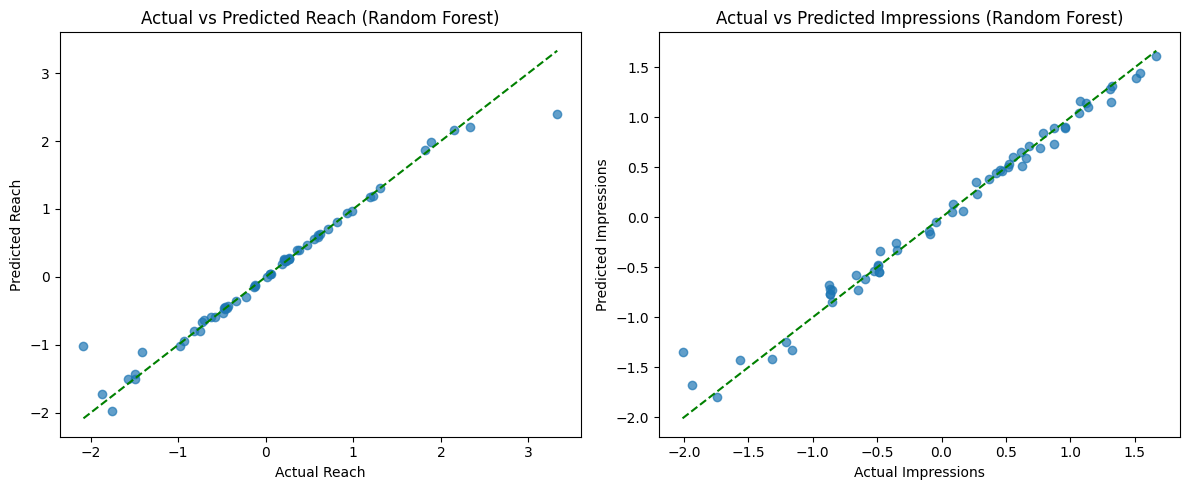

In [25]:
# 12. Actual vs Predicted Plot for Best Model
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test.iloc[:, 0], y_pred_best[:, 0], alpha=0.7)
plt.plot([y_test['yj_Reach'].min(), y_test['yj_Reach'].max()],
         [y_test['yj_Reach'].min(), y_test['yj_Reach'].max()], '--g')
plt.xlabel("Actual Reach")
plt.ylabel("Predicted Reach")
plt.title(f"Actual vs Predicted Reach ({best_name})")

plt.subplot(1, 2, 2)
plt.scatter(y_test.iloc[:, 1], y_pred_best[:, 1], alpha=0.7)
plt.plot([y_test['yj_Impressions'].min(), y_test['yj_Impressions'].max()],
         [y_test['yj_Impressions'].min(), y_test['yj_Impressions'].max()], '--g')
plt.xlabel("Actual Impressions")
plt.ylabel("Predicted Impressions")
plt.title(f"Actual vs Predicted Impressions ({best_name})")

plt.tight_layout()
plt.show()

In [26]:
# 13. Cross-Validation for Best Model
cv_r2 = cross_val_score(best_model, X_awareness, y_awareness, scoring='r2', cv=5)
cv_rmse = np.sqrt(-cross_val_score(best_model, X_awareness, y_awareness, scoring='neg_mean_squared_error', cv=5))
cv_mae = -cross_val_score(best_model, X_awareness, y_awareness, scoring='neg_mean_absolute_error', cv=5)

In [30]:
print(f"""
### ✅ Traffic Campaign Modeling Summary

We tested 4 models to predict Reach and Impressions:

🔹 **Best Model:** {best_name}  
📈 Reach R²: {metrics_summary[2]['Reach R2']:.4f}  
📈 Impressions R²: {metrics_summary[2]['Impressions R2']:.4f}  

✅ **Cross-Validation Results:**  
Avg R²: {np.mean(cv_r2):.4f}  
Avg RMSE: {np.mean(cv_rmse):.4f}  
Avg MAE: {np.mean(cv_mae):.4f}

The scatter plots confirm this model's predictions align closely with actual values.
""")


### ✅ Traffic Campaign Modeling Summary

We tested 4 models to predict Reach and Impressions:

🔹 **Best Model:** Random Forest  
📈 Reach R²: 0.9650  
📈 Impressions R²: 0.9828  

✅ **Cross-Validation Results:**  
Avg R²: 0.9401  
Avg RMSE: 0.2209  
Avg MAE: 0.1112

The scatter plots confirm this model's predictions align closely with actual values.



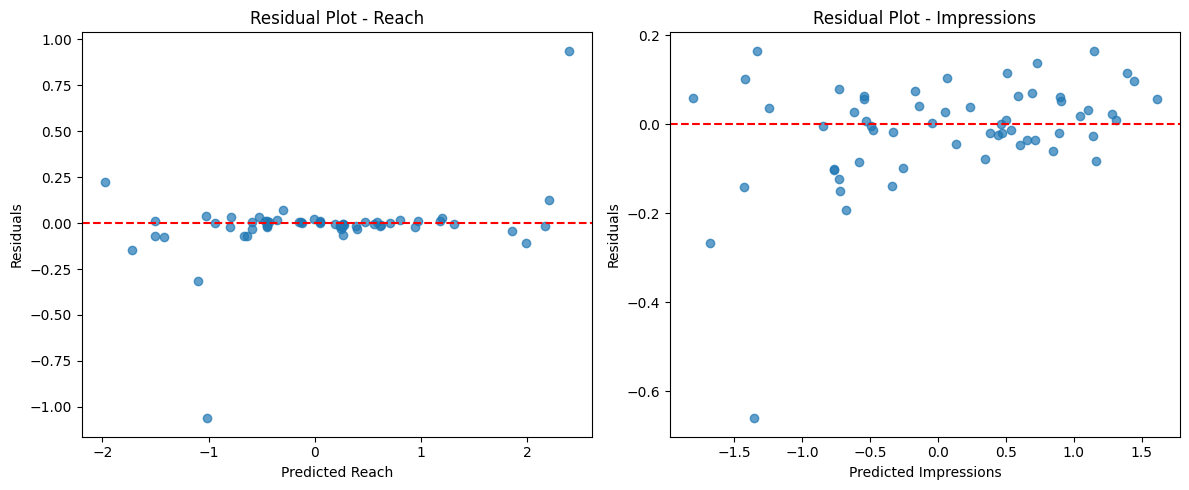

In [31]:
# 14. Residual Plot for Best Model
residuals_reach = y_test.iloc[:, 0] - y_pred_best[:, 0]
residuals_impressions = y_test.iloc[:, 1] - y_pred_best[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_best[:, 0], residuals_reach, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Reach")
plt.ylabel("Residuals")
plt.title("Residual Plot - Reach")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_best[:, 1], residuals_impressions, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Impressions")
plt.ylabel("Residuals")
plt.title("Residual Plot - Impressions")

plt.tight_layout()
plt.show()

In [32]:
# 17. Save best model
joblib.dump(best_model, f"models/{best_name.lower().replace(' ', '_')}_awareness_model.joblib")

['models/random_forest_awareness_model.joblib']